# Ergodic and localized Floquet quantum circuits (FQC)

Tutorial and Python codes by Nicolas Macé (mace@irsamc.ups-tlse.fr)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.insert(0, 'lib/')
import Circuit as circuit
import Ising_observables as observables
%load_ext autoreload
%autoreload 2

In this notebook, we consider the simple "Kicked Ising" Floquet model whose Floquet evolution operator is a depth two quantum circuit:
$$
    U_F = W_2 W_1,
$$
with the first layer dephasing neighboring spins:
$$
    W_1 = \left(\bigotimes_{j=1}^{L} \exp\left[-i h^z_{j} \sigma_j^z\right]\right)
    \left(\bigotimes_{j=1}^{L-1} \exp\left[-i J_{j}\sigma_j^z\sigma_{j+1}^z\right]\right),
$$
and the second layer flipping spins:
$$
    W_2 = \bigotimes_{j=1}^{L} \exp\left[-i (h^x_{j} \sigma_j^x + h^y_{j} \sigma_j^y)\right].
$$

This notebook is based on the following references:
* Zhou and Luitz, Phys. Rev. B **95**, 094206 (2017)
* Yao *et al*, Phys. Rev. Lett. **118**, 030401 (2017)


As outlined in the notes, there are several strategies to numerically deal with quantum circuits.
Here we adopt the most straightforward one: we write the local gates the circuit is made of as matrices. This is done in the `Circuit` class by the `compute_Z` and `compute_XY` methods, which respectively compute the first and second layers introduced above.
We choose (as is usual) the basis whose vectors are simultaneous eigenvectors of the $\sigma^z$ Pauli matrices.
Because the gates are local in this basis, the corresponding matrices are *sparse*, allowing us to perform fast matrix-vector multiplications and hence fast computation of the time evolution of the state.

# Ergodic system
To begin with, we consider the translation invariant model: $h_j^\alpha = \text{cst}, J_j = \text{cst}$ (eqns 31-32 in *Zhou and Luitz*).

Let us begin by writing the function that returns the FQC.

In [2]:
def KI(L):
    """
    Non-random kicked Ising model
    see https://arxiv.org/abs/1612.07327 (eqns 31-32)
    """
    tau = 0.8
    hx, hy, hz = 0.9045, 0.3457, 0.8090
    hx = [tau*hx]*L
    hy = [tau*hy]*L
    hz = [tau*hz]*L
    Jz = [tau]*L
    return circuit.KickedIsing(L, hx, hy, hz, Jz)

Starting from a state $\psi(0)$, let us note $|\psi(t)\rangle = U_F^t |\psi(0)\rangle$ the state of the system after $t$ Floquet drives.
We expect an ergodic model to quickly entangle an initially disentangled state $\psi(0)$:
$$
    S[\psi(t)] = v_E s_E t
$$
where $s_E = \ln 2$ is the maximum entropy per site, and $v_E$ is the entanglement velocity.
The entanglement velocity is bounded by $v_c$, the light-cone velocity: $v_E \leq v_c$.
Here, $v_c = 1$ since the circuit only involves one- and two-qubit gates.

Let us now write the functions that let us compute the entanglement entropy. We choose the Neel state as our initial state.

In [3]:
def get_neel(L):
    """
    Return the vector corresponding to the Neel state 1010...
    """
    # index of the Neel state in the computational basis
    ineel = int('10'*(L//2), 2)
    # Neel state vector
    state = np.zeros(2**L)
    state[ineel] = 1.0
    return state

def time_loop(L, tmax):
    """
    Time evolve the Neel state, computing the half-chain entanglement entropy at each time step.
    """
    op = KI(L)
    LA = L//2
    state = get_neel(L)
    ent = []
    for t in range(tmax):
        state = op.apply(state)
        cur_ent = observables.vNM_entropy(LA, state)
        ent.append(cur_ent)
    return ent

The QC nature the model lets us very easily compute the exact time evolution of our state: we simply serially apply each local gate (stored as a sparse matrix) on the state at a given time step to get the state at the next. This is done by the `apply` method of the `Circuit` class.
On a laptop, we can quickly access relatively large system sizes ($L \simeq 20$), whose full exact diagonalization would be unfeasable.

In [4]:
sizes = range(10, 22, 2)
tmax = 12
ents = [time_loop(L, tmax) for L in sizes]

We observe that the half-chain entanglement entropy almost saturates the bound:
$$
    v_E \lesssim \ln 2.
$$
This is a good hint that the KI model with this choice of parameters is close to being maximally chaotic. Also notice that the entropy reaches its maximal value at time $t_M = L/2$, and then saturates.

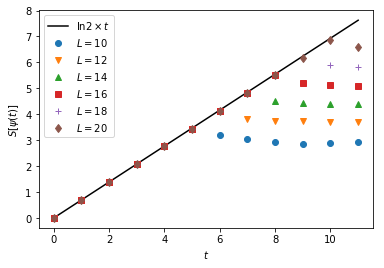

In [5]:
fig, ax = plt.subplots()
times = range(tmax)
ax.plot(times, np.log(2)*times, 'k-', label=r'$\ln 2 \times t$')
markers = ["o","v","^","s","+","d"]
for L, ent, marker in zip(sizes, ents, markers):
    ax.plot(times, ent, 'o', marker=marker, label=f'$L={L}$')
plt.ylabel('$S[\psi(t)]$')
plt.xlabel('$t$')
plt.legend()
plt.show()

# Localized system: time crystallinity

We now introduce disorder in the model, driving the system into a Floquet MBL phase and small enough interaction $J^z$. Following *Yao et al*, the couplings of the model are now of the following form:
$$
    J^z_j \in [J^z - \delta J^z, J^z + \delta J^z], \text{ with } \delta J^z = 0.2 J^z,\\
    h^z_j \in [0, 2\pi],\\
    h^x_j = \frac{\pi}{2} - \epsilon,\\
    h^y = 0,\\
$$
We have introduced here the *spin-echo imperfection* $\epsilon$, whose physical meaning we discuss below.
For the moment, let us simply write a routine that returns the FQC for some values of the input parameters.

In [6]:
def randomKI(L, epsilon, Jz, seed):
    """
    L: system size
    epsilon: spin echo imperfection
    Jz: interaction strength
    seed: random state seed
    
    Return: random Kicked Ising FQC
    """
    state = np.random.RandomState(seed)
    g = np.pi/2.
    hx = [g - epsilon]*L
    hy = np.zeros(L)
    hz = state.uniform(0, 2*np.pi, size=L) # maximal disorder
    deltaJz = 0.2*Jz
    Jzs = state.uniform(Jz - deltaJz, Jz + deltaJz, size=L)
    return circuit.KickedIsing(L, hx, hy, hz, Jzs)

We now come to the role of the spin-echo imperfection $\epsilon$.
For $\epsilon = 0$, $U_1$ simply flips the spins up to a global phase.
If furthermore $J_z=0$, $U_2$ acts trivially on computation basis states: their dynamics is thus a perfect spin-echo.
In that case, the spin auto-correlation function $R(t) = \langle \sigma_j^z(t) \sigma_j^z(0) \rangle$ is periodic with twice the Floquet period.
This model therefore spontaneously breaks the time translation symmetry.
The addition of a spin-echo imperfection $\epsilon > 0$ destroys the period doubling phenomenon.
However, it is restored by the addition of interactions $J_z > 0$.
The interacting random kicked Ising model is thus an example of *time crystal*.

Let us now check these claims by simulation the dynamics of the system. We begin by writing our main function: a loop on time, with the measurement of a few observables at each time step.

In [8]:
def FQC_timeevol(op, state0, tmax, LA, jautoc):
    """
    op: FQC we consider
    state0: initial state written in the configuration basis
    tmax: number of time steps
    LA: number of sites in the A subsystem (for entanglement entropy measure)
    jautoc: site at which we measure the spin autocorrelation function
    
    Return: von Neumann entanglement entropy, spin auto-correlation function
    """
    state = state0.copy()
    # useful to measure autocorrelation
    Zstate0 = op.apply_Z(jautoc, state)
    Zstate = Zstate0.copy()
    ent, R = [], []
    for t in range(tmax):
        # time evolve the state
        state = op.apply(state)
        Zstate = op.apply(Zstate)
        # measure entropy
        cur_ent = observables.vNM_entropy(LA, state)
        ent.append(cur_ent)  
        # measure autocorrelation
        ZZstate = op.apply_Z(jautoc, Zstate)
        cur_R = np.conj(state) @ ZZstate
        R.append(cur_R)
    return np.array(ent), np.array(R)

## Non-interacting, perfect spin-echo
We begin by checking that we observe perfect spin-echo in the non-interacting, spin-echo imperfection-free case. We initially prepare our system in the Neel state.

In [9]:
L = 14
# Neel state vector
state0 = get_neel(L)
# do time evolution
tmax = 100
times = range(tmax)
LA = L//2
jautoc = L//2
op = randomKI(L, epsilon=0.0, Jz=0.0, seed=42)
ent0, R0 = FQC_timeevol(op, state0, tmax, LA, jautoc)

lib/Ising_observables.py:9: RuntimeWarning: divide by zero encountered in log
  H = lambda x, cutoff: np.where(x < cutoff, 0., -x*np.log(x))
lib/Ising_observables.py:9: RuntimeWarning: invalid value encountered in multiply
  H = lambda x, cutoff: np.where(x < cutoff, 0., -x*np.log(x))


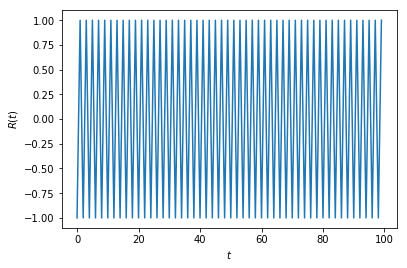

In [10]:
fig, ax = plt.subplots()
label0 = r'$\epsilon=0,J_z=0$'
ax.plot(times, R0.real, label=label0)
plt.xlabel('$t$')
plt.ylabel('$R(t)$')
plt.show()

## Non-interacting, imperfect spin-echo
Adding spin-echo imperfection destroys the period doubling phenomenon.

In [11]:
epsilon = 0.1
op = randomKI(L, epsilon=epsilon, Jz=0.0, seed=42)
ent1, R1 = FQC_timeevol(op, state0, tmax, LA, jautoc)

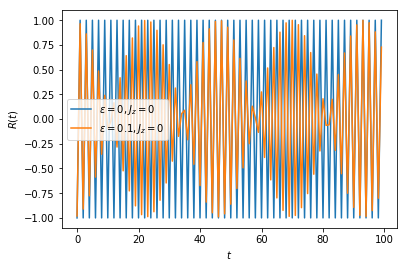

In [12]:
fig, ax = plt.subplots()
ax.plot(times, R0.real, label=label0)
label1 = f'$\epsilon={epsilon},J_z=0$'
ax.plot(times, R1.real, label=label1)
plt.xlabel('$t$')
plt.ylabel('$R(t)$')
plt.legend()
plt.show()

## Interacting, imperfect spin-echo
Finally, adding interactions stabilizes the period-doubling: this observation is compatible with the fact that the system is MBL and exhibits time crystallinity.

In [13]:
epsilon = 0.1
Jz = 0.15
op = randomKI(L, epsilon=epsilon, Jz=Jz, seed=42)
ent2, R2 = FQC_timeevol(op, state0, tmax, LA, jautoc)

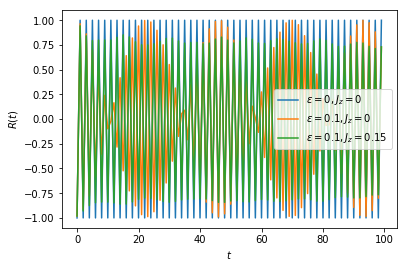

In [14]:
fig, ax = plt.subplots()
ax.plot(times, R0.real, label=label0)
ax.plot(times, R1.real, label=label1)
label2 = f'$\epsilon={epsilon},J_z={Jz}$'
ax.plot(times, R2.real, label=label2)
plt.xlabel('$t$')
plt.ylabel('$R(t)$')
plt.legend()
plt.show()

## Subharmonic response
To more quantitavely probe time crystallinity, we can Fourier transform the time series.
The subharmonic response at $\omega = 0.5$ signals the onset of period-doubling.

In [15]:
epsilon = 0.1
Jz = 0.15
op = randomKI(L, epsilon=epsilon, Jz=Jz, seed=42)
ent2, R2 = FQC_timeevol(op, state0, tmax, LA, jautoc)

In [16]:
tmax = 1000
op = randomKI(L, epsilon=0, Jz=0, seed=42)
ent0, R0 = FQC_timeevol(op, state0, tmax, LA, jautoc)
epsilon = 0.1
op = randomKI(L, epsilon=epsilon, Jz=0, seed=42)
ent1, R1 = FQC_timeevol(op, state0, tmax, LA, jautoc)
Jz = 0.15
op = randomKI(L, epsilon=epsilon, Jz=Jz, seed=42)
ent2, R2 = FQC_timeevol(op, state0, tmax, LA, jautoc)

As expected, we observe:
1. a strong subharmonic response for the non-interacting system with perfect spin-echo,
2. no subharmonic response for the non-interacting system with imperfect spin-echo,
3. a subharmonic response for the interacting system with imperfect spin-echo, signalling MBL time-crystallinity.

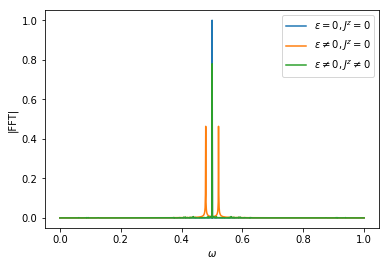

In [17]:
labels = [r'$\epsilon=0, J^z = 0$', r'$\epsilon \neq 0, J^z = 0$', r'$\epsilon \neq 0, J^z \neq 0$']
fig, ax = plt.subplots()
for R, label in zip([R0,R1,R2], labels):
    FFT = np.fft.fft(R.real - np.mean(R.real))
    # normalize
    FFT = FFT/len(R)
    freqs = np.linspace(0, 1, len(FFT))
    ax.plot(freqs, np.abs(FFT), label=label)
plt.xlabel('$\omega$')
plt.ylabel('|FFT|')
# ax.set_yscale('log')
plt.legend()
plt.show()